In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import scipy.misc
import glob
from matplotlib.patches import Polygon

In [94]:
def getCameraCallibrationResults(img, nx = 9, ny = 6):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    objPoints = []
    imgPoints = []
    
    objPointsDetected = np.zeros((nx * ny, 3), np.float32)
    objPointsDetected[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    if ret == True:
        objPoints.append(objPointsDetected)
        imgPoints.append(corners)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints, imgPoints, gray.shape[::-1], None, None)
        return  ret, mtx, dist, rvecs, tvecs
    else:
        return (None,None,None,None,None)

Text(0.5,1,'Undistorted Image')

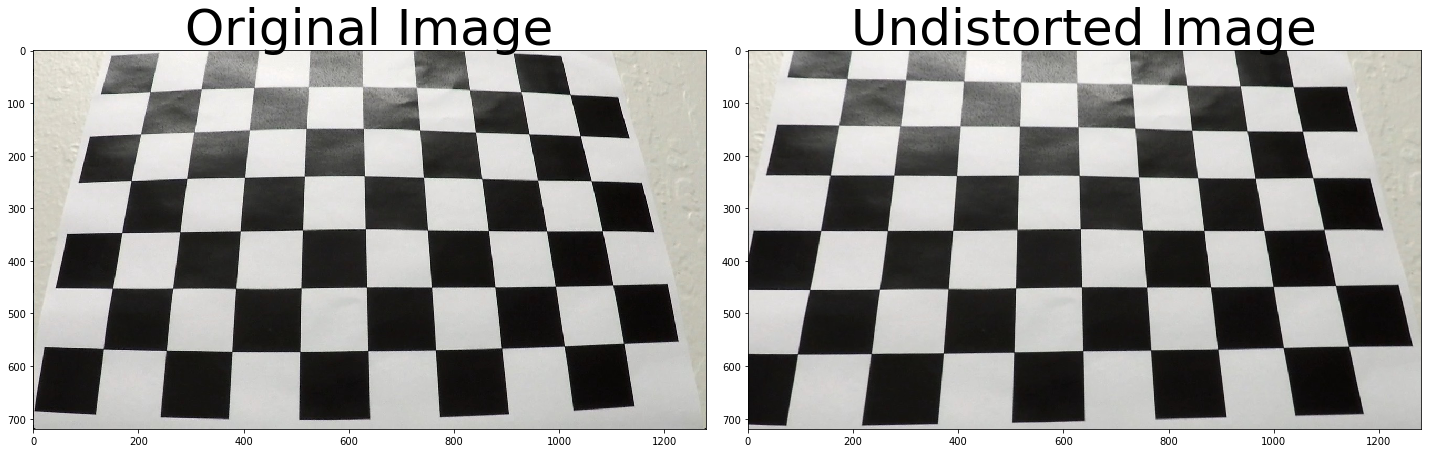

In [95]:
path = "camera_cal/calibration3.jpg"
chessImage = mpimg.imread(path)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()
ax1.imshow(chessImage)
ax1.set_title('Original Image', fontsize=50)
ret, cameraMatrix, distortionCoefficients, rvecs, tvecs = getCameraCallibrationResults(chessImage)
undistort = cv2.undistort(chessImage, cameraMatrix, distortionCoefficients, None, cameraMatrix)
ax2.imshow(undistort)
ax2.set_title('Undistorted Image', fontsize=50)

In [119]:
def abs_sobel_thresh(img, orient, sobel_kernel=3, thresh = (0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel = []
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    absoluteValue = np.absolute(sobel)
    scaledSobel = np.uint8(255*absoluteValue/np.max(absoluteValue))
    sbinary = np.zeros_like(scaledSobel)
    sbinary[(scaledSobel > thresh[0]) & (scaledSobel < thresh[1])] = 1
    return sbinary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelX = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobelY = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    absoluteValue = np.sqrt(sobelX**2 + sobelY**2)
    scale_factor = np.max(absoluteValue)/255 
    scaledSobel = (absoluteValue/scale_factor).astype(np.uint8)
    sBinary = np.zeros_like(scaledSobel)
    sBinary[(scaledSobel > mag_thresh[0]) & (scaledSobel < mag_thresh[1])] = 1
    return sBinary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelX = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobelY = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobelY), np.absolute(sobelX))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1]) & (l_channel > 100)] = 1
    return binary_output

def gradientAndColorThreshold(img):
    ksize = 3
    
    image = np.copy(img)
    
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(0, 255))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.2))
    hls_binary = hls_select(image, thresh=(90, 255))
    
    combined = np.zeros_like(dir_binary)
    combined[(gradx == 1) & (grady == 1)| (hls_binary == 1)] = 1
    return combined

def perspectiveTransform(img):
    src = np.float32([[600,460],[740,460],[1150,700],[230,700]])
    dst = np.float32([[230,0],[1150,0],[1150,720],[230,720]])
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.plot(Polygon(src).get_xy()[:, 0], Polygon(src).get_xy()[:, 1], color='red')
    ax1.imshow(img)
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
    ax2.imshow(warped)
    return warped

def pipeline(img):
    perspectiveTransform(img)
#     gradientImage = gradientAndColorThreshold(img)
#     return gradientImage

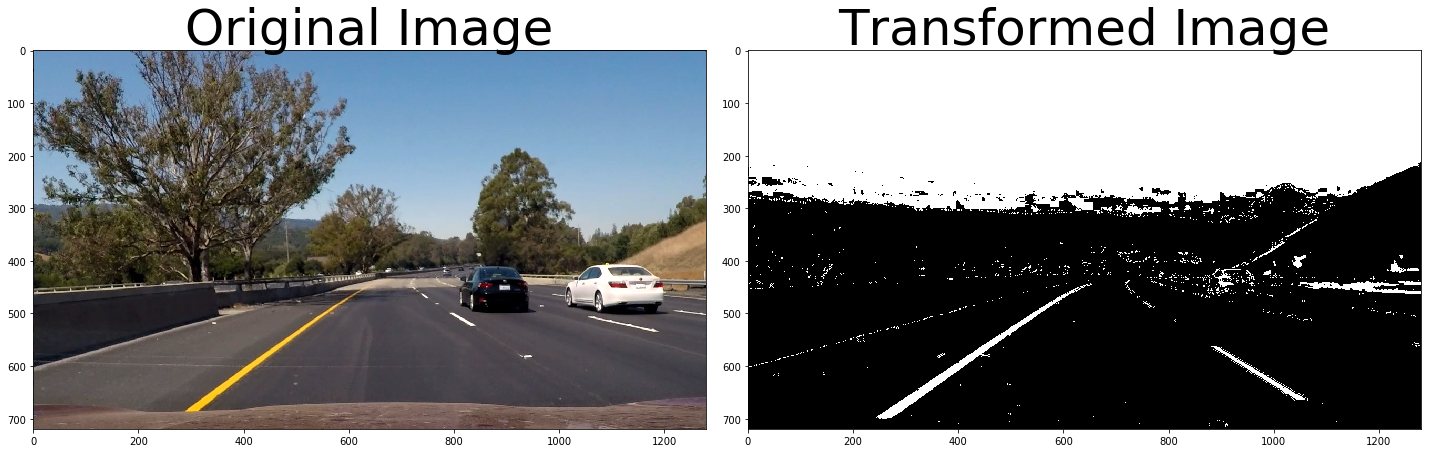

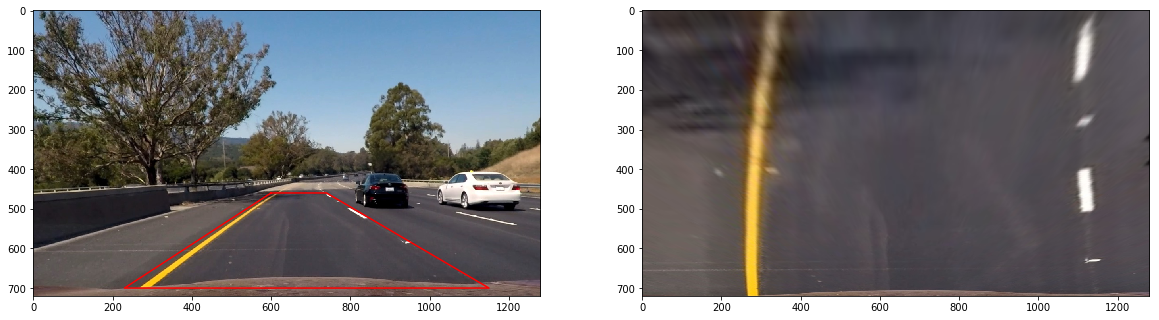

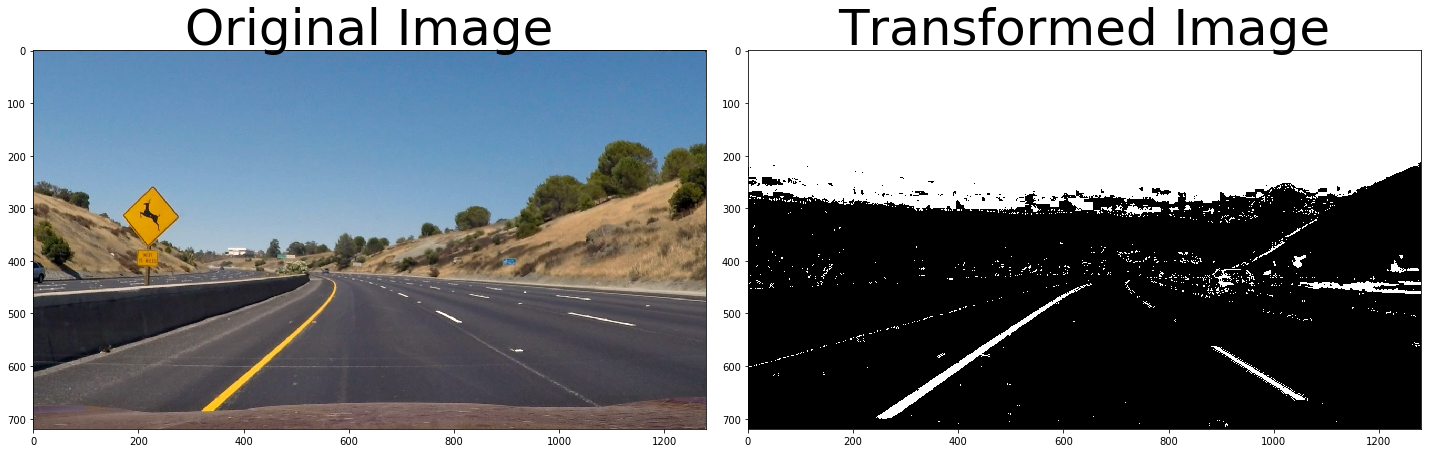

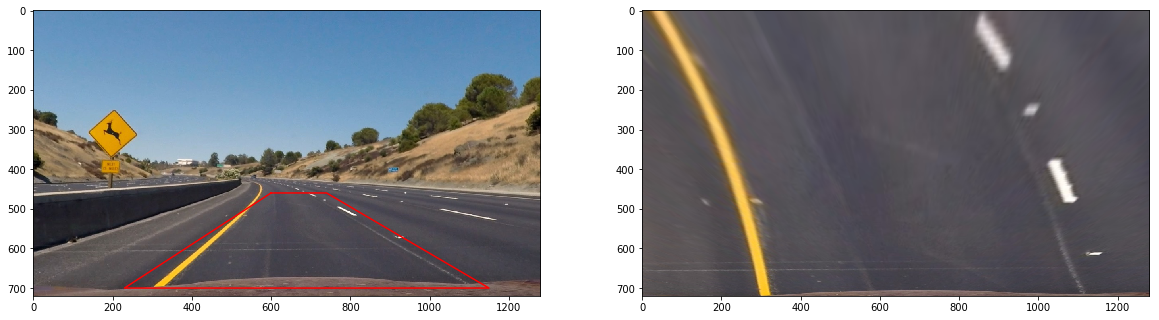

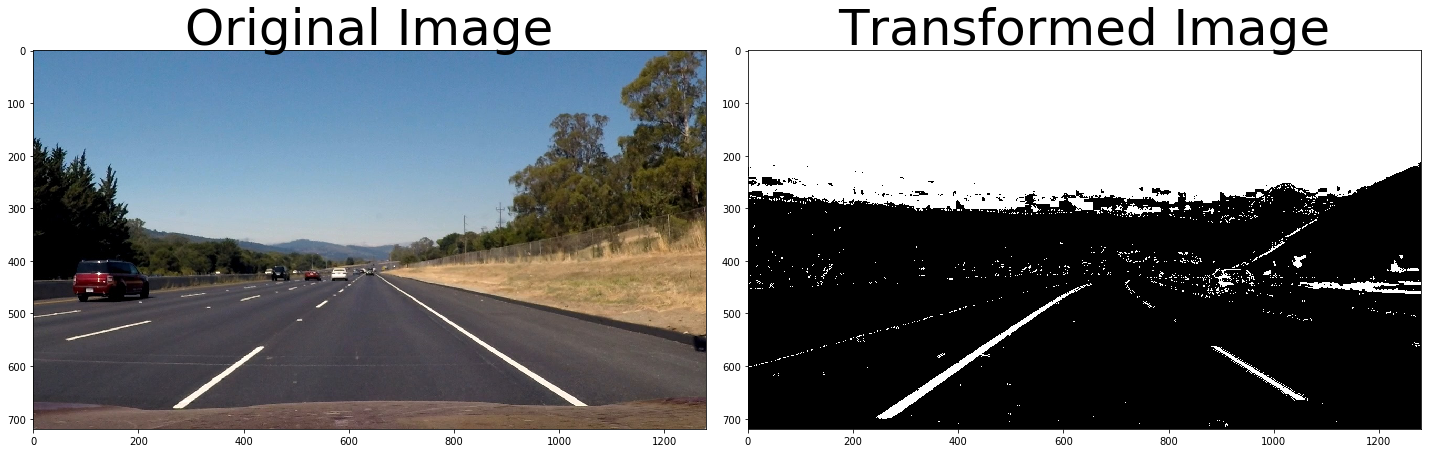

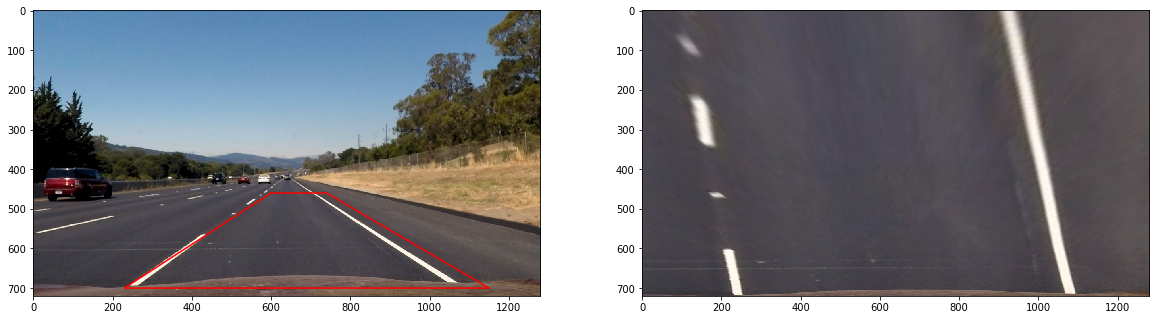

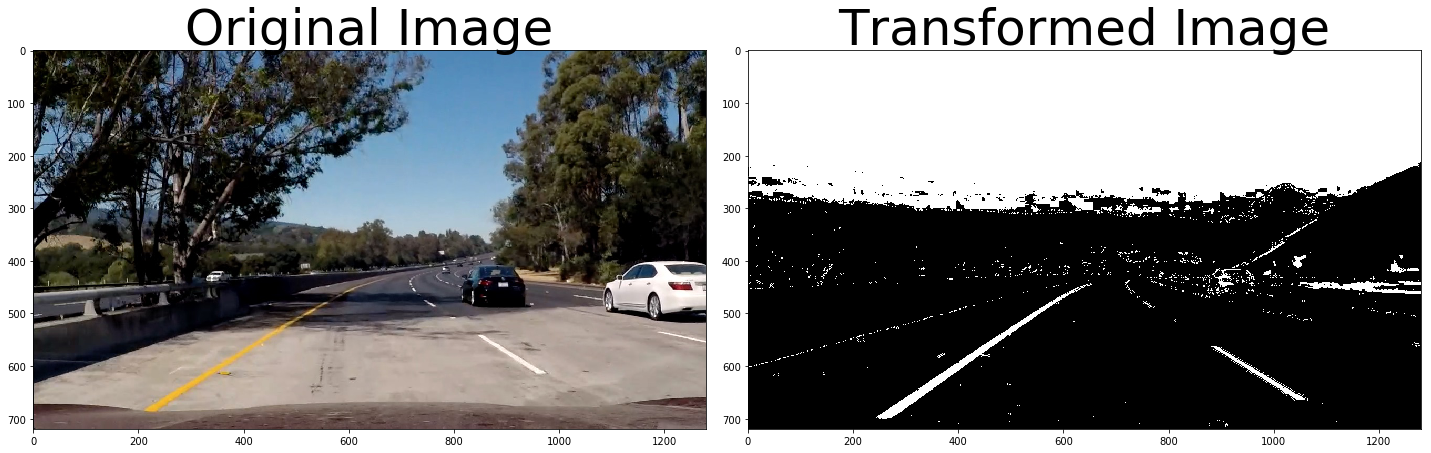

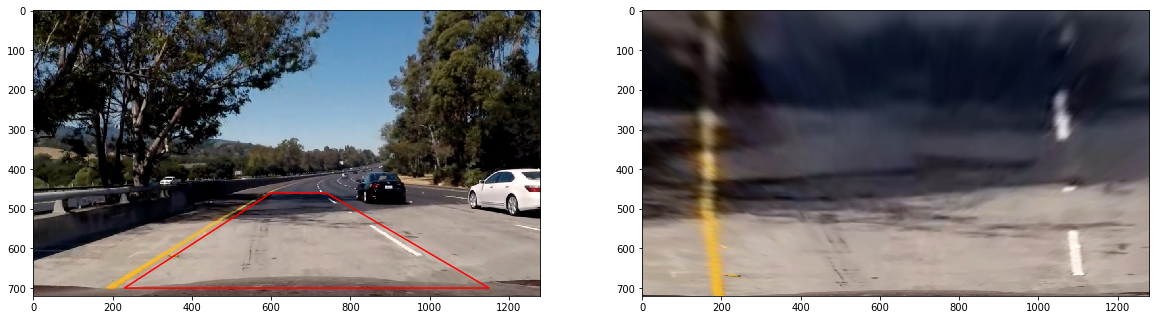

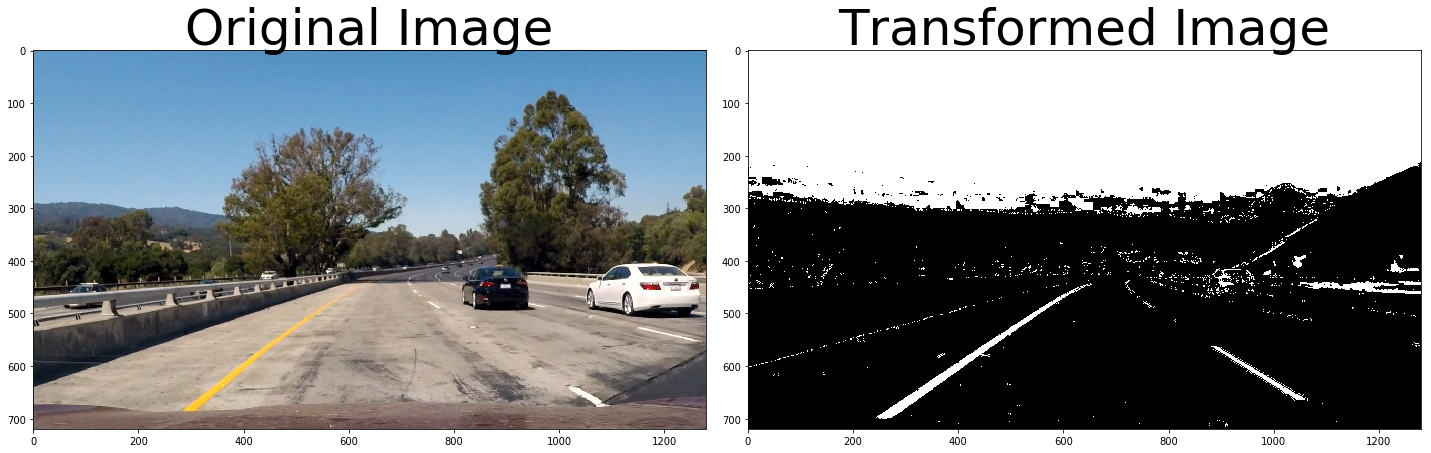

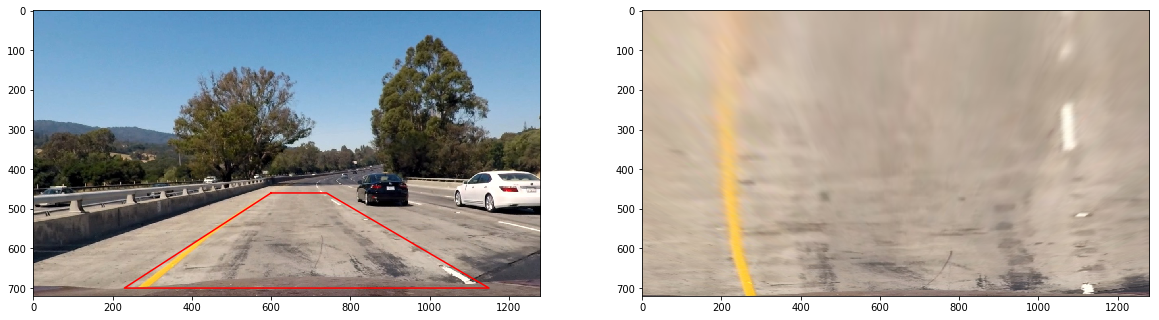

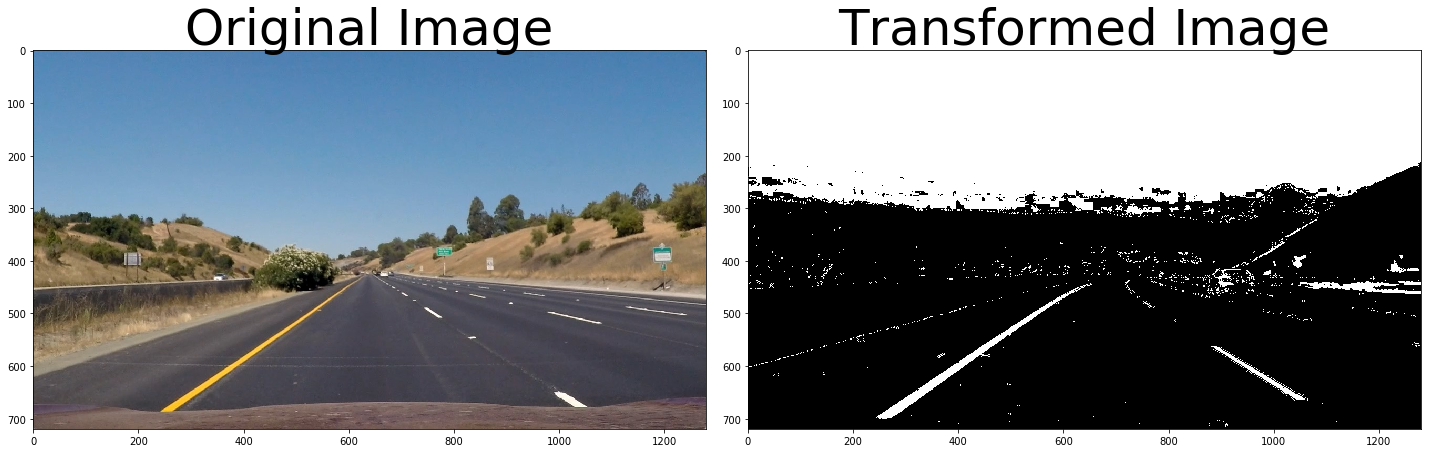

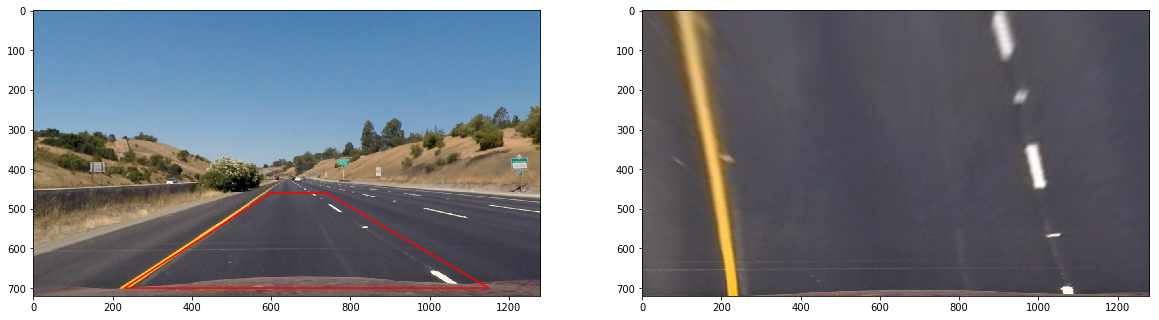

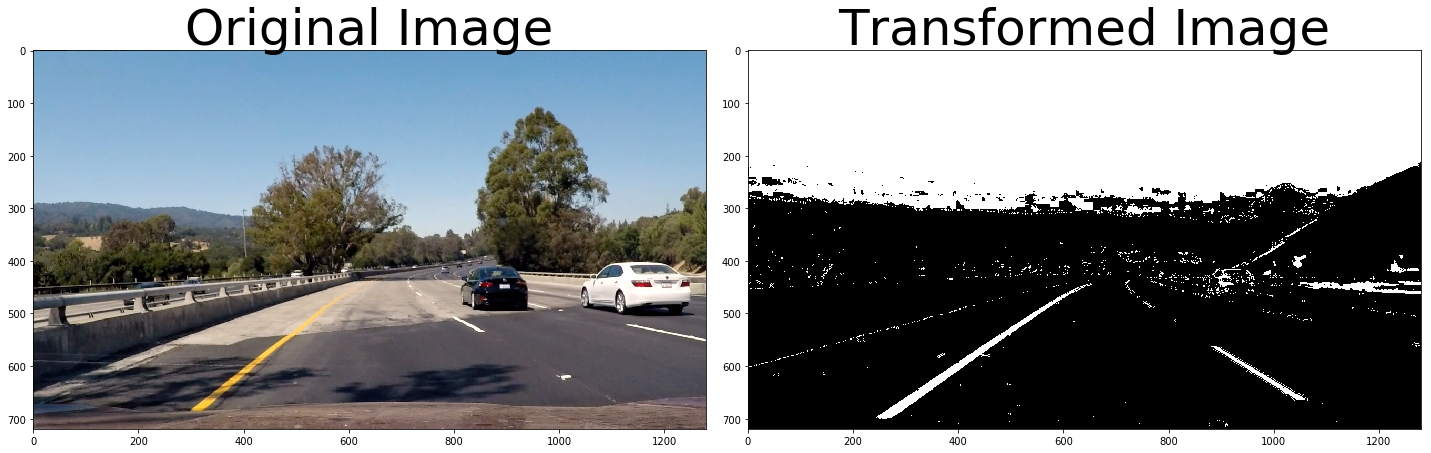

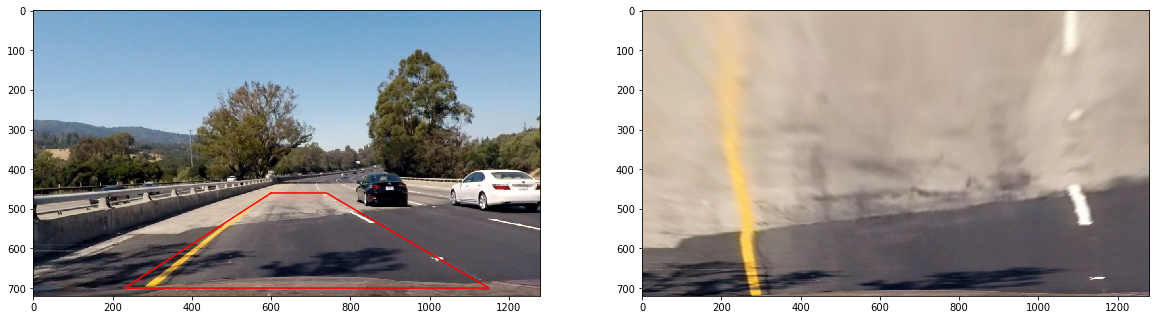

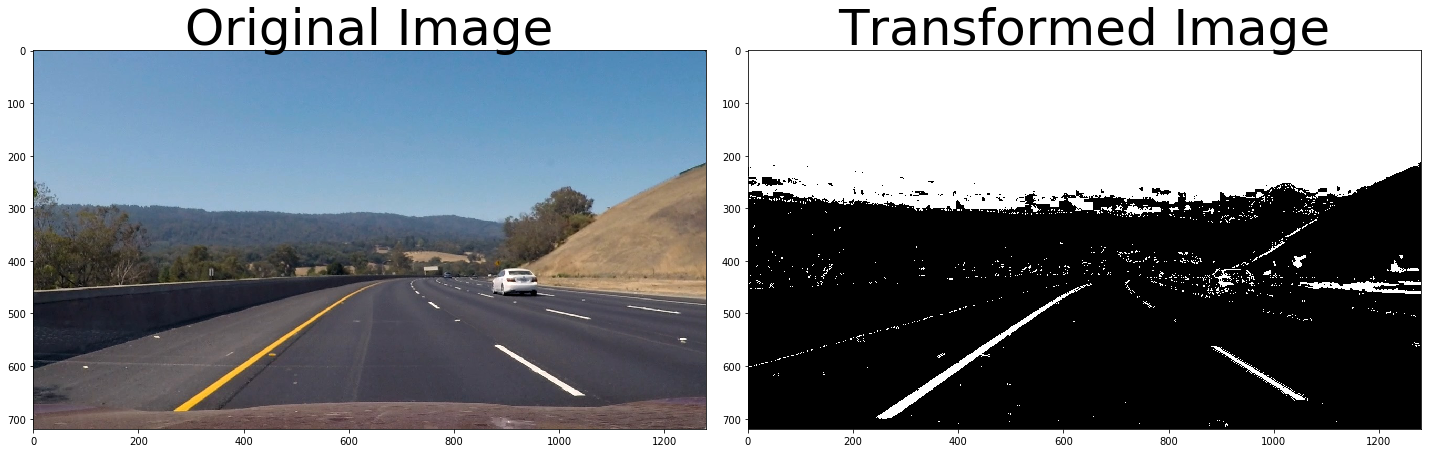

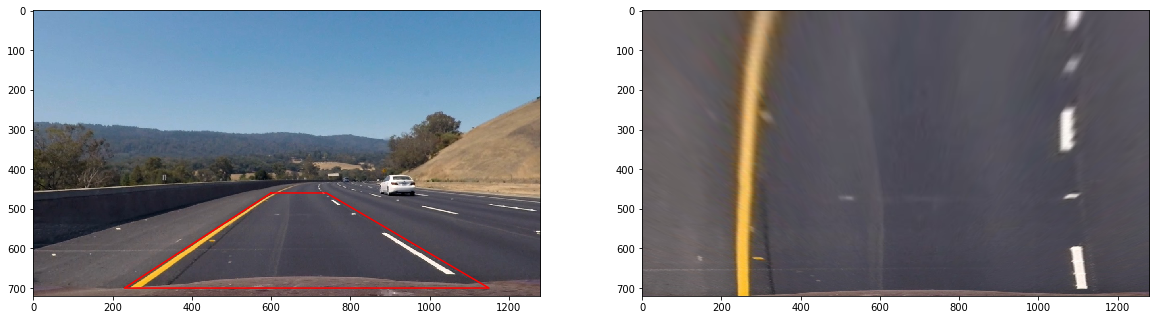

In [120]:
path = "test_images/"
testImageStrings = os.listdir(path)
for testImageString in testImageStrings:
    testImage = mpimg.imread(path + testImageString)
    undistortedTestImage = cv2.undistort(testImage, cameraMatrix, distortionCoefficients, None, cameraMatrix)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    f.tight_layout()
    ax1.imshow(testImage)
    ax1.set_title('Original Image', fontsize=50)
#     gradient = 
    pipeline(undistortedTestImage)
    ax2.imshow(gradient, cmap='gray')
    ax2.set_title('Transformed Image', fontsize=50)

In [ ]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  